## Importação dos pacotes

In [1]:
# importar pacotes necessários
import numpy as np
import pandas as pd

In [2]:
# definir parâmetros extras
#pd.set_option('precision', 2)
pd.set_option('display.max_columns', 100)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# importar pacotes usados na seleção do modelo e na medição da precisão
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# importar os pacotes necessários para os algoritmos de regressão
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

## Carga dos dados de entrada

In [5]:
# carregar arquivo de dados de treino
filename = 'abalone-train.csv'
#filename = 'https://github.com/hjort/ai-labs/raw/master/kaggle/serpro-abalone/abalone-train.csv'
data = pd.read_csv(filename, index_col='id')

# mostrar tamanho
print(data.shape)

# mostrar alguns exemplos de registros
data.head()

(2784, 9)


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
id,,,,,,,,,
2758,M,0.535,0.430,0.155,0.7845,0.3285,0.1690,0.2450,10
1384,F,0.630,0.485,0.170,1.3205,0.5945,0.3450,0.3450,9
1131,M,0.565,0.435,0.150,0.9900,0.5795,0.1825,0.2060,8
3726,I,0.500,0.395,0.145,0.7865,0.3320,0.1815,0.2455,8
3445,I,0.495,0.400,0.145,0.5780,0.2545,0.1305,0.1645,8


In [6]:
# gerar "one hot encoding" em atributos categóricos
data = pd.get_dummies(data)
data.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
id,,,,,,,,,,,
2758,0.535,0.430,0.155,0.7845,0.3285,0.1690,0.2450,10,0,0,1
1384,0.630,0.485,0.170,1.3205,0.5945,0.3450,0.3450,9,1,0,0
1131,0.565,0.435,0.150,0.9900,0.5795,0.1825,0.2060,8,0,0,1
3726,0.500,0.395,0.145,0.7865,0.3320,0.1815,0.2455,8,0,1,0
3445,0.495,0.400,0.145,0.5780,0.2545,0.1305,0.1645,8,0,1,0


In [7]:
# encontrar possíveis outliers
outliers = np.concatenate((
    data[(data['height'] < 0.01) | (data['height'] > 0.3)].index,
    data[(data['viscera_weight'] < 0.0001) | (data['viscera_weight'] > 0.6)].index
), axis=0)

# exibir outliers
data[data.index.isin(outliers)].head(10)

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
id,,,,,,,,,,,
1763,0.775,0.630,0.250,2.7795,1.3485,0.7600,0.5780,12,0,0,1
1417,0.705,0.565,0.515,2.2100,1.1075,0.4865,0.5120,10,0,0,1
3996,0.315,0.230,0.000,0.1340,0.0575,0.0285,0.3505,6,0,1,0


In [8]:
# remover outliers detectados
print("Número de outliers a serem removidos: %d" % len(outliers))

print("Antes:", data.shape)
data.drop(outliers, inplace=True)
print("Depois:", data.shape)

Número de outliers a serem removidos: 3
Antes: (2784, 11)
Depois: (2781, 11)


In [9]:
# realizar normalização nos dados numéricos contínuos
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data.loc[:,'length':'shell_weight'] = scaler.fit_transform(data.loc[:,'length':'shell_weight'])

data.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
id,,,,,,,,,,,
2758,0.621622,0.630252,0.604167,0.307345,0.263158,0.285835,0.275608,10,0,0,1
1384,0.750000,0.722689,0.666667,0.517871,0.476898,0.584394,0.388795,9,1,0,0
1131,0.662162,0.638655,0.583333,0.388060,0.464845,0.308736,0.231466,8,0,0,1
3726,0.574324,0.571429,0.562500,0.308130,0.265970,0.307040,0.276174,8,0,1,0
3445,0.567568,0.579832,0.562500,0.226237,0.203696,0.220526,0.184493,8,0,1,0


In [10]:
# definir dados de entrada
X = data.drop(['rings'], axis=1) # tudo, exceto a coluna alvo
y = data['rings'] # apenas a coluna alvo

print('Forma dos dados originais:', X.shape, y.shape)

Forma dos dados originais: (2781, 10) (2781,)


## Treinamento dos modelos preditivos

In [11]:
from sklearn.metrics import make_scorer, mean_squared_error

# cria função para cálculo do RMSE (REMQ)
def root_mean_squared_error(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5

RMSE = make_scorer(root_mean_squared_error, greater_is_better=False)

In [12]:
from datetime import datetime

# avalia o desempenho do modelo, retornando o valor do RMSE
def evaluate_model_cv(model, X=X, y=y):
    start = datetime.now()
    kfold = KFold(n_splits=10, random_state=42)
    results = cross_val_score(model, X, y, cv=kfold, scoring=RMSE, verbose=1)
    end = datetime.now()
    elapsed = int((end - start).total_seconds() * 1000)
    score = (-1) * results.mean()
    stddev = results.std()
    print(model, '\nScore: %.2f (+/- %.2f) [%5s ms]' % (score, stddev, elapsed))
    return score, stddev, elapsed

In [13]:
# faz o ajuste fino do modelo, calculando os melhores hiperparâmetros
def fine_tune_model(model, params, X=X, y=y):
  print('\nFine Tuning Model:')
  print(model, "\nparams:", params)
  kfold = KFold(n_splits=10, random_state=42)
  grid = GridSearchCV(estimator=model, param_grid=params, scoring=RMSE, cv=kfold, verbose=1)
  grid.fit(X, y)
  print('\nGrid Best Score: %.2f' % (grid.best_score_ * (-1)))
  print('Best Params:', grid.best_params_)
  return grid

## Avaliação e ajuste fino de cada modelo preditivo

-  https://scikit-learn.org/stable/modules/classes.html

### Generalized Linear Models

In [14]:
model = LinearRegression(n_jobs=-1, fit_intercept=True, normalize=True)
evaluate_model_cv(model)

params = dict(
    fit_intercept=[True, False],
    normalize=[True, False]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True) 
Score: 2.21 (+/- 0.17) [ 1270 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


In [15]:
model = LogisticRegression(n_jobs=-1, random_state=42, multi_class='auto', C=1000, solver='sag')
evaluate_model_cv(model)

params = dict(
    solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    C=np.logspace(-3, 3, 7)
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='sag', tol=0.0001, verbose=0, warm_start=False) 
Score: 2.47 (+/- 0.22) [ 6243 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.2s finished


In [15]:
model = OrthogonalMatchingPursuit(n_nonzero_coefs=7, fit_intercept=True, normalize=True)
evaluate_model_cv(model)

params = dict(
    n_nonzero_coefs=[None, 1, 2, 5, 7],
    fit_intercept=[True, False],
    normalize=[True, False]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=7, normalize=True,
                          precompute='auto', tol=None) 
Score: 2.21 (+/- 0.17) [ 1093 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


In [16]:
model = PassiveAggressiveRegressor(random_state=42, C=0.2, fit_intercept=True, max_iter=1000, tol=0.001)
evaluate_model_cv(model)

params = {
    'C': [0.1, 0.2, 0.4, 0.8, 1.0],
    'fit_intercept': [True, False],
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


PassiveAggressiveRegressor(C=0.2, average=False, early_stopping=False,
                           epsilon=0.1, fit_intercept=True,
                           loss='epsilon_insensitive', max_iter=1000,
                           n_iter_no_change=5, random_state=42, shuffle=True,
                           tol=0.001, validation_fraction=0.1, verbose=0,
                           warm_start=False) 
Score: 2.36 (+/- 0.26) [  603 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


In [18]:
model = Perceptron(random_state=42, penalty=None, alpha=1e-6, fit_intercept=True, max_iter=1000, tol=1e-3)
evaluate_model_cv(model)

#penalty=None, alpha=0.0001, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, eta0=1.0,
#n_jobs=None, random_state=0, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
#class_weight=None, warm_start=False

params = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(-6, -1, 6),
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Perceptron(alpha=1e-06, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 3.24 (+/- 0.48) [  219 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [19]:
model = RANSACRegressor(random_state=42, min_samples=0.75)
evaluate_model_cv(model)

#base_estimator=None, min_samples=None, residual_threshold=None, is_data_valid=None, is_model_valid=None,
#max_trials=100, max_skips=inf, stop_n_inliers=inf, stop_score=inf, stop_probability=0.99, loss=’absolute_loss’,
#random_state=None

params = {
    'min_samples': [None, 0.1, 0.25, 0.5, 0.75, 1.0]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
                loss='absolute_loss', max_skips=inf, max_trials=100,
                min_samples=0.75, random_state=42, residual_threshold=None,
                stop_n_inliers=inf, stop_probability=0.99, stop_score=inf) 
Score: 2.23 (+/- 0.19) [  635 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


In [20]:
model = Ridge(random_state=42, alpha=0.1, fit_intercept=True, normalize=False)
evaluate_model_cv(model)

#alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver=’auto’,
#random_state=None

params = {
    'alpha': np.logspace(-6, -1, 6),
    'fit_intercept': [True, False],
    'normalize': [True, False]
}
#fine_tune_model(model, params)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='auto', tol=0.001) 
Score: 2.21 (+/- 0.18) [   19 ms]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [21]:
model = SGDRegressor(random_state=42, alpha=1e-4, fit_intercept=True, penalty='l1', tol=1e-3)
evaluate_model_cv(model)

#loss=’squared_loss’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001,
#shuffle=True, verbose=0, epsilon=0.1, random_state=None, learning_rate=’invscaling’, eta0=0.01, power_t=0.25,
#early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, warm_start=False, average=False

params = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(-6, -1, 6),
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False) 
Score: 2.29 (+/- 0.22) [  619 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


In [22]:
model = TheilSenRegressor(random_state=42, n_jobs=-1, fit_intercept=True)
evaluate_model_cv(model)

#fit_intercept=True, copy_X=True, max_subpopulation=10000.0, n_subsamples=None, 
#max_iter=300, tol=0.001, random_state=None, n_jobs=None, verbose=False

params = {
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
                  max_subpopulation=10000, n_jobs=-1, n_subsamples=None,
                  random_state=42, tol=0.001, verbose=False) 
Score: 2.22 (+/- 0.16) [ 4969 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.0s finished


### Decision Trees

In [23]:
model = DecisionTreeRegressor(random_state=42, max_depth=4, min_samples_split=0.25)
evaluate_model_cv(model)

#criterion=’mse’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, 
#min_impurity_decrease=0.0, min_impurity_split=None, presort=False

params = dict(
    max_depth=[4, 6, 8, 10, 12, 14],
    min_samples_split=[0.25, 0.5, 0.75, 1.0]
)
#fine_tune_model(model, params)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=0.25, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best') 
Score: 2.50 (+/- 0.22) [   41 ms]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


### Gaussian Processes

In [24]:
model = GaussianProcessRegressor(random_state=42, alpha=0.01, normalize_y=True)
evaluate_model_cv(model)

#kernel=None, alpha=1e-10, optimizer=’fmin_l_bfgs_b’, n_restarts_optimizer=0,
#normalize_y=False, copy_X_train=True, random_state=None

params = dict(
    alpha=np.logspace(-6, -1, 6),
    normalize_y=[True, False]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianProcessRegressor(alpha=0.01, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=42) 
Score: 2.14 (+/- 0.17) [ 2578 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s finished


### Kernel Ridge Regression

In [25]:
model = KernelRidge(alpha=0.1)
evaluate_model_cv(model)

#alpha=1, kernel=’linear’, gamma=None, degree=3, coef0=1, kernel_params=None

params = dict(
    alpha=np.logspace(-6, -1, 6)
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None) 
Score: 2.21 (+/- 0.18) [ 1324 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


### Naïve Bayes

In [26]:
model = GaussianNB(var_smoothing=0.001)
evaluate_model_cv(model)

#priors=None, var_smoothing=1e-09

params = dict(
    var_smoothing=np.logspace(-9, -1, 5)
)
#fine_tune_model(model, params)

GaussianNB(priors=None, var_smoothing=0.001) 
Score: 5.26 (+/- 0.45) [   54 ms]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


### Nearest Neighbors

In [27]:
model = KNeighborsRegressor(n_jobs=-1, n_neighbors=13, weights='distance')
evaluate_model_cv(model)

#n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’,
#metric_params=None, n_jobs=None

params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance']
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                    weights='distance') 
Score: 2.28 (+/- 0.21) [  183 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


### Support Vector Machines

In [28]:
model = SVR(gamma='auto', kernel='linear')
evaluate_model_cv(model)

#kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, tol=0.001, C=1.0, 
#epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1

params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']#, 'precomputed']
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 
Score: 2.34 (+/- 0.24) [ 2015 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished


### Neural network models

In [17]:
model = MLPRegressor(random_state=42, max_iter=500, activation='tanh', hidden_layer_sizes=(80,40,20), solver='lbfgs')
evaluate_model_cv(model)

#hidden_layer_sizes=(100, ), activation=’relu’, solver=’adam’, alpha=0.0001, batch_size=’auto’, 
#learning_rate=’constant’, learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
#random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
#early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10

params = dict(
    hidden_layer_sizes=[(100,), (50,), (50,2), (5,5,2), (10,5,2)],
    activation=['identity', 'logistic', 'tanh', 'relu'],
    solver=['lbfgs', 'sgd', 'adam']
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(80, 40, 20), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False) 
Score: 2.25 (+/- 0.19) [681273 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 11.4min finished


### Ensemble Methods

In [30]:
model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=100, max_depth=9)
evaluate_model_cv(model)

#n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
#verbose=0, warm_start=False

params = {
    'n_estimators': [5, 10, 25, 50, 75, 100],
    'max_depth': [None, 3, 5, 7, 9, 11, 13]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False) 
Score: 2.18 (+/- 0.19) [ 3718 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.7s finished


In [31]:
model = GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=100, subsample=0.8, max_depth=4, max_features=0.85)
evaluate_model_cv(model)

#loss=’ls’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’, min_samples_split=2,
#min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
#min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, 
#max_leaf_nodes=None, warm_start=False, presort=’auto’, validation_fraction=0.1, n_iter_no_change=None, 
#tol=0.0001

params = dict(
    n_estimators=[100, 250, 500],
    max_features=[0.75, 0.85, 1.0],
    max_depth=[4, 6, 8, 10],
    learning_rate=[0.05, 0.1, 0.15],
    subsample=[0.4, 0.6, 0.8]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=0.85, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 2.18 (+/- 0.20) [ 1266 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


In [32]:
model = ExtraTreesRegressor(random_state=42, n_jobs=-1, n_estimators=200, max_features=0.75)
evaluate_model_cv(model)

#n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=None, random_state=None, verbose=0,
#warm_start=False

params = dict(
    n_estimators=[50, 75, 100, 200],
    max_features=['auto', 0.75, 0.85, 1.0]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features=0.75, max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                    oob_score=False, random_state=42, verbose=0,
                    warm_start=False) 
Score: 2.23 (+/- 0.19) [ 4092 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.1s finished


In [33]:
model = BaggingRegressor(random_state=42, n_jobs=-1, base_estimator=DecisionTreeRegressor(), max_features=0.75, n_estimators=75)
evaluate_model_cv(model)

#base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, 
#bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0

params = dict(
    n_estimators=[50, 75, 100, 200],
    max_features=[0.5, 0.75, 1.0]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort=False,
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=True, bootstrap_features=False, max_features=0.75,
                 max_sampl

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


In [34]:
model = AdaBoostRegressor(random_state=42, n_estimators=200, base_estimator=DecisionTreeRegressor())
evaluate_model_cv(model)

# base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm=’SAMME.R’, random_state=None

params = dict(
    n_estimators=[50, 75, 100, 200]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=200,
                  rand

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.3s finished


### Outros algoritmos

#### XGBoost

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [18]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.1, n_estimators=50, max_depth=5, objective='reg:squarederror')
evaluate_model_cv(model)

#max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='reg:squarederror',
#booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, 
#colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
#base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain'

params = dict(
    max_depth=[3, 5, 7, 9],
    n_estimators=[50, 75, 100, 200]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a futur

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1) 
Score: 2.21 (+/- 0.20) [16274 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.3s finished


### Ensemble Learning Model

- https://towardsdatascience.com/automate-stacking-in-python-fc3e7834772e
- https://github.com/vecxoz/vecstack

In [ ]:
# https://towardsdatascience.com/ensemble-learning-using-scikit-learn-85c4531ff86a

# classe não disponível no pacote :P
#from sklearn.ensemble import VotingRegressor
#conda update scikit-learn
#pip install -U scikit-learn

estimators =  [
    ('MLP', MLPRegressor(random_state=42, max_iter=500,
                     activation='tanh', hidden_layer_sizes=(5,5,2), solver='lbfgs')),
    ('GPR', GaussianProcessRegressor(random_state=42, alpha=0.01, normalize_y=True)),
    ('GBR', GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=100,
                                  subsample=0.8, max_depth=4, max_features=0.85))
    #('RFR', RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=100, max_depth=7)),
    #('ETR', ExtraTreesRegressor(random_state=42, n_jobs=-1, n_estimators=100)),
    #('XGBR', XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.1,
    #             n_estimators=50, max_depth=5, objective='reg:squarederror'))
]

model = VotingRegressor(estimators, n_jobs=-1, weights=(2,1,1))
evaluate_model_cv(model)

#estimators, weights=None, n_jobs=None

params = dict(
    weights=[(1,1,1), (5,4,3), (2,1,1), (3,2,1)]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


## Comparação final entre os algoritmos

In [37]:
models = []

# Generalized Linear Models
models.append(('LinReg', LinearRegression(n_jobs=-1, fit_intercept=True, normalize=True)))
models.append(('LogReg', LogisticRegression(n_jobs=-1, random_state=42, multi_class='auto', C=1000, solver='sag')))
models.append(('OMP', OrthogonalMatchingPursuit(n_nonzero_coefs=7, fit_intercept=True, normalize=True)))
models.append(('PAR', PassiveAggressiveRegressor(random_state=42, C=0.2, fit_intercept=True, max_iter=1000, tol=0.001)))
models.append(('PP', Perceptron(random_state=42, penalty=None, alpha=1e-6, fit_intercept=True, max_iter=1000, tol=1e-3)))
models.append(('RANSAC', RANSACRegressor(random_state=42, min_samples=0.75)))
models.append(('Ridge', Ridge(random_state=42, alpha=0.1, fit_intercept=True, normalize=False)))
models.append(('SGD', SGDRegressor(random_state=42, alpha=1e-4, fit_intercept=True, penalty='l1', tol=1e-3)))
models.append(('TSR', TheilSenRegressor(random_state=42, n_jobs=-1, fit_intercept=True)))

# Decision Trees
models.append(('DTR', DecisionTreeRegressor(random_state=42, max_depth=4, min_samples_split=0.25)))

# Gaussian Processes
models.append(('GPR', GaussianProcessRegressor(random_state=42, alpha=0.01, normalize_y=True)))

# Kernel Ridge Regression
models.append(('KRR', KernelRidge(alpha=0.1)))

# Naïve Bayes
models.append(('GNB', GaussianNB(var_smoothing=0.001)))

# Nearest Neighbors
models.append(('kNN', KNeighborsRegressor(n_jobs=-1, n_neighbors=13, weights='distance')))

# Support Vector Machines
models.append(('SVM', SVR(gamma='auto', kernel='linear')))

# Neural network models
models.append(('MLP', MLPRegressor(random_state=42, max_iter=500,
                     activation='tanh', hidden_layer_sizes=(5,5,2), solver='lbfgs')))

# Ensemble Methods
models.append(('RFR', RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=100, max_depth=9)))
models.append(('GBR', GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=100, subsample=0.8, max_depth=4, max_features=0.85)))
models.append(('ETR', ExtraTreesRegressor(random_state=42, n_jobs=-1, n_estimators=200, max_features=0.75)))
models.append(('BDTR', BaggingRegressor(random_state=42, n_jobs=-1, base_estimator=DecisionTreeRegressor(), max_features=0.75, n_estimators=75)))
models.append(('ABDTR', AdaBoostRegressor(random_state=42, n_estimators=200, base_estimator=DecisionTreeRegressor())))

# XGBoost
models.append(('XGBR', XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.1, n_estimators=50, max_depth=5, objective='reg:squarederror')))

# Voting
models.append(('VR', VotingRegressor(estimators=[
    ('MLP', MLPRegressor(random_state=42, max_iter=500, activation='tanh', hidden_layer_sizes=(5,5,2), solver='lbfgs')),
    ('GPR', GaussianProcessRegressor(random_state=42, alpha=0.01, normalize_y=True)),
    ('GBR', GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=100, subsample=0.8, max_depth=4, max_features=0.85))
], n_jobs=-1, weights=(2,1,1))))

In [38]:
results = []
names = []
scores = []
stddevs = []
times = []

for name, model in models:
    score, stddev, elapsed = evaluate_model_cv(model, X=X, y=y)
    results.append((score, stddev))
    names.append(name)
    scores.append(score)
    stddevs.append(stddev)
    times.append(elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True) 
Score: 2.21 (+/- 0.17) [   25 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='sag', tol=0.0001, verbose=0, warm_start=False) 
Score: 2.47 (+/- 0.22) [ 4060 ms]
OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=7, normalize=True,
                          precompute='auto', tol=None) 
Score: 2.21 (+/- 0.17) [   25 ms]
PassiveAggressiveRegressor(C=0.2, average=False, early_stopping=False,
                           epsilon=0.1, fit_intercept=True,
                           loss='epsilon_insensitive', max_iter=1000,
                           n_iter_no_change=5, random_state=42, shuffle=True,
                           tol=0.001, validation_fraction=0.1, verbose=0,
                           warm_start=False) 
Score: 2.36 (+/- 0.26) [   37 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Perceptron(alpha=1e-06, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 3.24 (+/- 0.48) [  200 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
                loss='absolute_loss', max_skips=inf, max_trials=100,
                min_samples=0.75, random_state=42, residual_threshold=None,
                stop_n_inliers=inf, stop_probability=0.99, stop_score=inf) 
Score: 2.23 (+/- 0.19) [  614 ms]
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='auto', tol=0.001) 
Score: 2.21 (+/- 0.18) [   22 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False) 
Score: 2.29 (+/- 0.22) [  650 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
                  max_subpopulation=10000, n_jobs=-1, n_subsamples=None,
                  random_state=42, tol=0.001, verbose=False) 
Score: 2.22 (+/- 0.16) [ 4691 ms]
DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=0.25, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best') 
Score: 2.50 (+/- 0.22) [   35 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianProcessRegressor(alpha=0.01, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=42) 
Score: 2.14 (+/- 0.17) [ 2474 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None) 
Score: 2.21 (+/- 0.18) [ 1256 ms]
GaussianNB(priors=None, var_smoothing=0.001) 
Score: 5.26 (+/- 0.45) [   37 ms]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                    weights='distance') 
Score: 2.28 (+/- 0.21) [  148 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 
Score: 2.34 (+/- 0.24) [ 2046 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(5, 5, 2), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False) 
Score: 2.10 (+/- 0.17) [ 3332 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False) 
Score: 2.18 (+/- 0.19) [ 3698 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=0.85, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 2.18 (+/- 0.20) [ 1243 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features=0.75, max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                    oob_score=False, random_state=42, verbose=0,
                    warm_start=False) 
Score: 2.23 (+/- 0.19) [ 4365 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort=False,
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=True, bootstrap_features=False, max_features=0.75,
                 max_sampl

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/dados/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/dados/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/dados/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/dados/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/dados/anaconda3/lib/python3.7/site-packages/xgboost/core

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=200,
                  rand

/dados/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/dados/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1) 
Score: 2.21 (+/- 0.20) [  298 ms]
VotingRegressor(estimators=[('MLP',
                             MLPRegressor(activation='tanh', alpha=0.0001,
                                          batch_size='auto', beta_1=0.9,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(5, 5, 2),
                                          learning_rate='constant',
                 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.1s finished


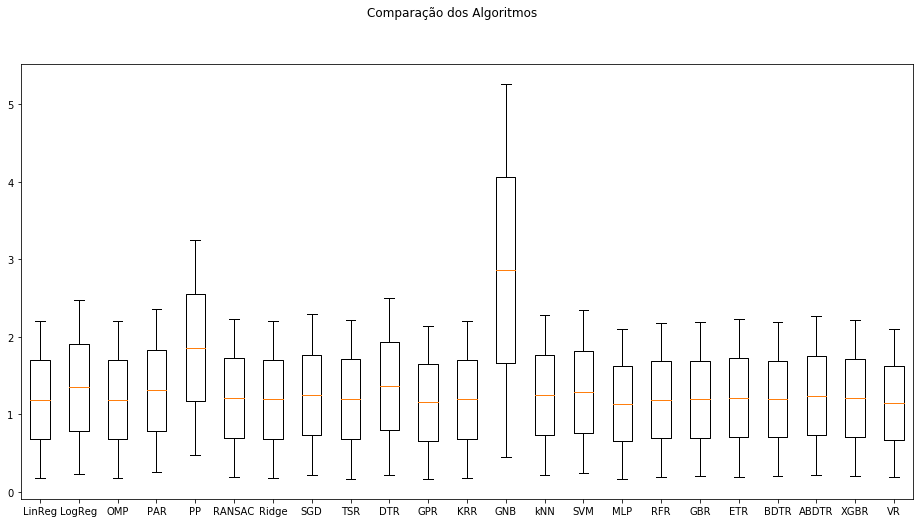

In [39]:
# comparar desempenhos dos algoritmos
fig = plt.figure(figsize=(16,8))
fig.suptitle('Comparação dos Algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [40]:
results_df = pd.DataFrame({'Model': names, 'Score': scores, 'Std Dev': stddevs, 'Time (ms)': times})
results_df.sort_values(by='Score', ascending=True)

,Model,Score,Std Dev,Time (ms)
22,VR,2.100961,0.185157,6066
15,MLP,2.102743,0.169970,3332
10,GPR,2.140225,0.165876,2474
16,RFR,2.177647,0.194311,3698
17,GBR,2.184430,0.202442,1243
19,BDTR,2.188667,0.203951,959
2,OMP,2.205400,0.171963,25
6,Ridge,2.206807,0.176342,22
11,KRR,2.206813,0.176310,1256
0,LinReg,2.207549,0.171718,25
